# Import das bibliotecas

In [402]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

# Variáveis das métricas dos modelos

In [403]:
acc_lr = []
f1_lr = []
acc_dt = []
f1_dt = []
acc_rf = []
f1_rf = []

# Leitura dos dados

In [404]:
data_training = pd.read_csv('falencia-treinamento.csv', delimiter=';')
data_test = pd.read_csv('falencia-teste.csv', delimiter=';')
data_result = pd.read_csv('modelo-submissao.csv', delimiter=';')

# Expansão do conjunto de treinamento

In [405]:
data_training_copy = data_training.copy()
data_training_expanded = pd.concat([data_training, data_training_copy])

# Divisão do conjunto de dados

In [406]:
# Divisão do conjunto de dados falencia-treinamento em dados de treinamento e dados de teste. Divisão de 70% treinamento e 30% testes
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(data_training_expanded.drop('Resultado', axis=1), data_training_expanded['Resultado'], test_size=0.3, random_state=42)

# Técnica Smote

In [407]:
# Técnica SMOTE para aplicar o Oversampling (criação de cópias da classe minoritária para que as classes fiquem equilibradas)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_init, y_train_init)

# Seleção de Características

In [408]:
# Seleciona as características mais importantes para o modelo usando o teste qui-quadrado
selector = SelectKBest(chi2, k=10)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)

# Validação Cruzada (KFold)

In [409]:
# kf = KFold(n_splits=5, shuffle=True, random_state=10)

# for train_index, test_index in kf.split(X_train_resampled):
#     # Split data into train and test sets
#     X_train, X_test = X_train_resampled.iloc[train_index], X_train_resampled.iloc[test_index]
#     y_train, y_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]

# Seleção Univariada

In [410]:
# selector = SelectKBest(chi2, k=15)
# X_new = selector.fit_transform(X_train_resampled, y_train_resampled)

# # Obtém os índices dos recursos selecionados
# selected_features = selector.get_support()

# # Obtém os nomes dos recursos selecionados
# selected_feature_names = X_train.columns[selected_features]

# # Substitui as variáveis X_train e X_test pelos recursos selecionados
# X_train_selected = X_train[selected_feature_names]
# X_test_selected = X_test[selected_feature_names]

# Recursive Feature Elimination (RFE)

In [411]:
# # Cria um objeto RFE para selecionar 10 atributos
# rfe = RFE(estimator=logistic_model, n_features_to_select=10)

# # Ajusta o modelo aos dados de treinamento resampleados e seleciona os atributos
# rfe.fit(X_train_resampled, y_train_resampled)

# # Obtém os índices dos recursos selecionados
# selected_features = rfe.support_

# # Obtém os nomes dos recursos selecionados
# selected_feature_names = X_train.columns[selected_features]

# # Substitui as variáveis X_train e X_test pelos recursos selecionados pela RFE
# X_train_selected = X_train[selected_feature_names]
# X_test_selected = X_test[selected_feature_names]

# Regressão Logística

In [412]:
def logistic_regression(X_train, y_train, X_test, y_test):
    # Cria um modelo de regressão logística
    logistic_model = LogisticRegression(max_iter = 1000)
    
    # Ajusta o modelo aos dados de treinamento
    logistic_model.fit(X_train, y_train)
    
    # Faz previsões nos dados de teste
    y_pred_lr = logistic_model.predict(X_test)

    # Calcula a acurácia do modelo nos dados de teste extraído dos de treinamento
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    f_measure_lr = f1_score(y_test, y_pred_lr)
    
    return accuracy_lr, f_measure_lr

# Árvore de Decisão

In [413]:
def decision_tree(X_train, y_train, X_test, y_test):
    # Cria um modelo de árvore de decisão com profundidade máxima de 3
    tree_model = DecisionTreeClassifier(min_samples_split=3)

    # Ajusta o modelo aos dados de treinamento
    tree_model.fit(X_train, y_train)

    # Faz previsões nos dados de teste
    y_pred_dt = tree_model.predict(X_test)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    f_measure_dt = f1_score(y_test, y_pred_dt)
    
    return accuracy_dt, f_measure_dt

# Random Forest

In [414]:
def random_forest(X_train, y_train, X_test, y_test):
    # Cria um modelo de Random Forest com 100 árvores de decisão
    rf_model = RandomForestClassifier(n_estimators=100)

    # Ajusta o modelo aos dados de treinamento
    rf_model.fit(X_train, y_train)

    # Faz previsões nos dados de teste
    y_pred_rf = rf_model.predict(X_test)

    # Calcula a acurácia e f-measure do modelo nos dados de teste
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    f_measure_rf = f1_score(y_test, y_pred_rf)
    
    return accuracy_rf, f_measure_rf

# Validação Cruzada (RepeatedKFold)

In [415]:
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

accuracy_lr_list = []
f_measure_lr_list = []
accuracy_dt_list = []
f_measure_dt_list = []
accuracy_rf_list = []
f_measure_rf_list = []

for train_index, test_index in kf.split(X_train_selected):
    # Split data into train and test sets
    X_train, X_test = X_train_selected[train_index], X_train_selected[test_index]
    y_train, y_test = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    
    # Regressão Logística
    accuracy_lr, f_measure_lr = logistic_regression(X_train, y_train, X_test, y_test)
    
    # Árvore de Decisão
    accuracy_dt, f_measure_dt = decision_tree(X_train, y_train, X_test, y_test)
    
    # Random Forest
    accuracy_rf, f_measure_rf = random_forest(X_train, y_train, X_test, y_test)
    
    accuracy_lr_list.append(accuracy_lr)
    f_measure_lr_list.append(f_measure_lr)
    accuracy_dt_list.append(accuracy_dt)
    f_measure_dt_list.append(f_measure_dt)
    accuracy_rf_list.append(accuracy_rf)
    f_measure_rf_list.append(f_measure_rf)

# Avaliação dos modelos

Logistic Regression:
Accuracy: 0.71
F-measure: 0.72

Decision Tree:
Accuracy: 0.91
F-measure: 0.91

Random Forest:
Accuracy: 0.93
F-measure: 0.93



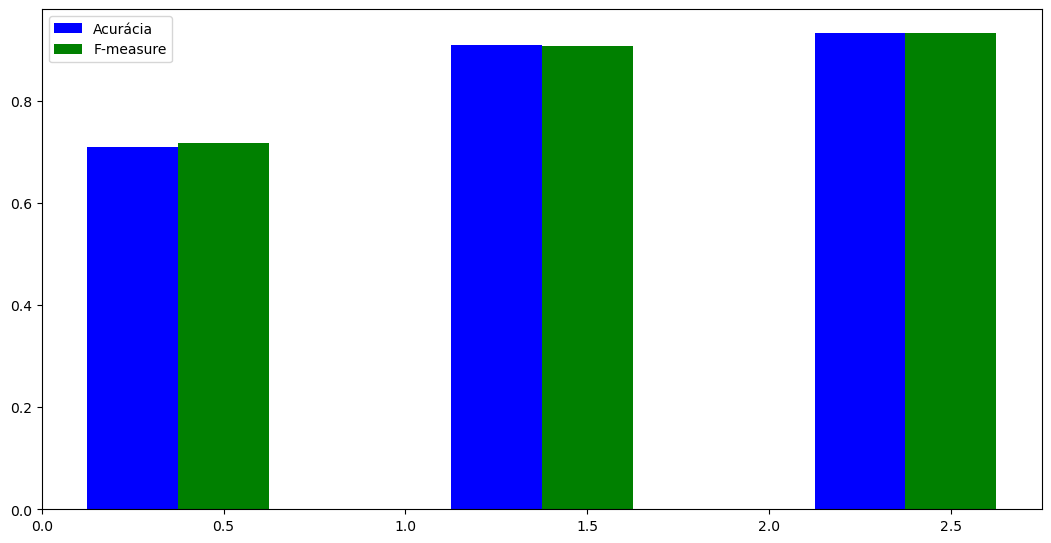

In [417]:
# Define as posições das barras
x_pos = np.arange(len(models))
x_pos = x_pos + 0.25

# Plota o gráfico
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(x_pos, accuracy, color='b', width=0.25)
ax.bar(x_pos + 0.25, f_measure, color='g', width=0.25)
ax.legend(['Acurácia', 'F-measure'])

# Exibe os valores finais
for i in range(len(models)):
    print(f'{models[i]}:')
    print(f'Accuracy: {round(accuracy[i], 2)}')
    print(f'F-measure: {round(f_measure[i], 2)}\n')

plt.show()